# Production System Simulation
## Modeling a Manufacturing Facility with Three Product Families

This notebook simulates a production system with:
- 6 working centers (each with capacity 1)
- 3 product families with different routing probabilities
- Gamma-distributed processing times
- Due dates uniformly distributed between 30-50 time units

Key performance indicators calculated:
- Average number of active jobs in system
- Work in Progress (WIP)
- Flow time
- Tardiness and Earliness (max and average)
- Throughput
- Working center utilization

In [36]:
# Install required packages
%pip install simpy numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [37]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
plt.style.use('ggplot')
import scipy.stats

## Simulation Parameters

In [38]:
# Simulation configuration
SIM_TIME = 20_000  # Total simulation time
WARM_UP = 2000    # Warm-up period to ignore in statistics (determined with Welch's method)

# Working center IDs
WC_IDS = [1, 2, 3, 4, 5, 6]

# Product family probabilities [F1, F2, F3]
FAMILY_PROBS = {1: 0.10, 2: 0.52, 3: 0.38}

# Gamma distribution parameters (alpha, beta) for each family
PROCESSING_PARAMS = {
    1: (2, 2),      # Family 1
    2: (4, 0.5),    # Family 2
    3: (6, 1/6)     # Family 3
}

# Routing logic: (WC, probability) for each family
ROUTING = {
    1: {1 : 1.0, 2 : 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
    2: {1: 0.8, 2: 0.8, 3: 1.0, 4: 0.8, 5: 0.8, 6: 0.75},
    3: {3: 1.0, 6: 0.75}
}

# Arrival rate (exponential distribution)
ARRIVAL_RATE = 0.65  # lambda

# Due times
DUE_TIME = (30, 50)

## System Visualization

Utility for visualizing service time distribution and routing probabilities for each product family.

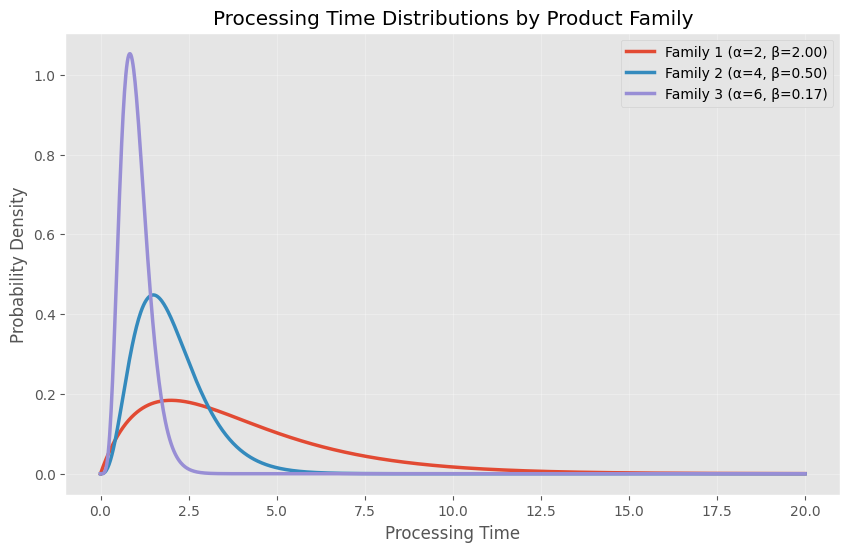

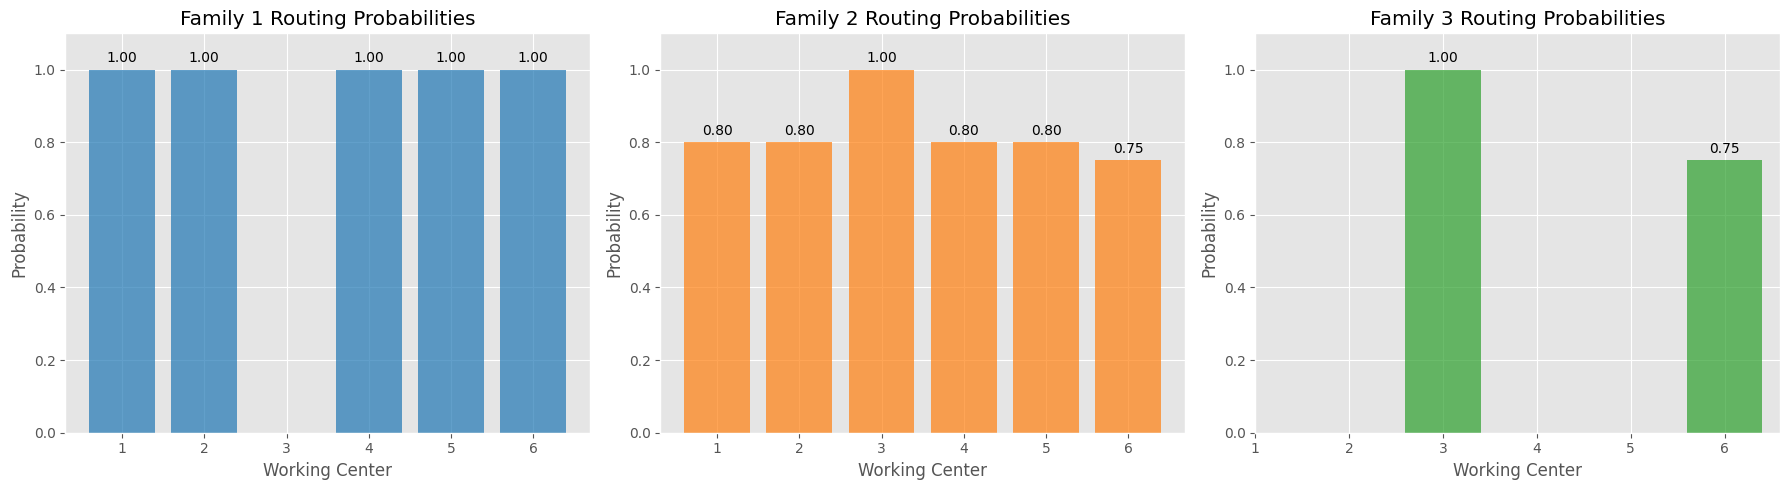

In [39]:
def visualize_processing_distributions():
    """Visualize gamma distributions for each product family"""
    plt.figure(figsize=(10, 6))
    
    # Generate x values
    x = np.linspace(0, 20, 1000)
    
    # Plot each family's distribution
    for family, (alpha, beta) in PROCESSING_PARAMS.items():
        y = gamma.pdf(x, alpha, scale=beta)
        plt.plot(x, y, label=f'Family {family} (α={alpha}, β={beta:.2f})', linewidth=2.5)
    
    plt.title('Processing Time Distributions by Product Family')
    plt.xlabel('Processing Time')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_routing_probabilities():
    """Visualize routing probabilities for each product family"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    wc_positions = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
    
    for idx, (family, routing) in enumerate(ROUTING.items()):
        ax = axes[idx]
        wcs = [wc for wc, _ in routing.items()]
        probs = [prob for _, prob in routing.items()]
        
        # Create positions
        positions = [wc_positions[wc] for wc in wcs]
        
        ax.bar(positions, probs, color=plt.cm.tab10(family-1), alpha=0.7)
        ax.set_title(f'Family {family} Routing Probabilities')
        ax.set_xlabel('Working Center')
        ax.set_ylabel('Probability')
        ax.set_xticks(list(wc_positions.values()))
        ax.set_xticklabels(list(wc_positions.keys()))
        ax.set_ylim(0, 1.1)
        
        # Add value labels
        for i, p in enumerate(probs):
            ax.text(positions[i], p + 0.02, f'{p:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

# Visualize system characteristics
visualize_processing_distributions()
visualize_routing_probabilities()

## Simulation Implementation

### Job class

Represents a production job with family, due date, and tracking times (arrival time, start time and finish time for each work center and completion time).

In [40]:
class Job:
    """Represents a production job with family, due date, and tracking times"""
    next_id = 1
    
    def __init__(self, env, family):
        self.jid = Job.next_id
        Job.next_id += 1
        self.family = family
        self.arrival_time = env.now
        self.due_date = self.arrival_time + random.uniform(DUE_TIME[0], DUE_TIME[1])
        self.completion_time: float | None = None
        self.routing = {}
        self.remaining_workload = 0.0
        for wc_id, wc_prob in ROUTING[self.family].items():
            if random.random() < wc_prob:
                alpha, beta = PROCESSING_PARAMS[self.family]
                processing_time = random.gammavariate(alpha, beta)
                self.routing[wc_id] = processing_time
                self.remaining_workload += processing_time
        
        
    def __repr__(self):
        return f"Job {self.jid} (F{self.family}) due @ {self.due_date:.2f} estimated worload = {self.remaining_workload}"
    
    def run(self, env : simpy.Environment, wcs : dict[int, simpy.Resource], stats, debug: bool = False):
        """Processes a job through its routing sequence"""
        # Record system statistics
        stats['generated'] += 1
        if env.now > WARM_UP:
            time_spent = env.now - stats['last_active_jobs_update_time']
            stats['active_jobs_time_at_level'][stats['last_active_jobs_count']] += time_spent
        stats['last_active_jobs_update_time'] = env.now
        stats['last_active_jobs_count'] += 1  # Job enters system

        # update total workload when job arrives
        stats['total_remaining_workload'] += self.remaining_workload
        stats['workload_events'].append((env.now, stats['total_remaining_workload']))
        
        # Record family-specific statistics
        stats['family_counts'][self.family] += 1
        
        # Record arrival time for this family
        stats['arrival_times'][self.family].append(env.now)

        if debug:
            print(f"\n[🆕 ARRIVAL @ {env.now:.2f}] {self} ")

        for wc_id, processing_time in self.routing.items():
            wc = wcs[wc_id]
            with wc.request() as req:
                if debug:
                    print(f"[⏳ QUEUE @ {env.now:.2f}] {self} "
                        f"waiting for WC {wc_id}")
                # Record queue start time
                queue_start = env.now
                
                # Request the working center
                yield req
                
                # Record queue time
                queue_time = env.now - queue_start
                stats['queue_times'][wc_id].append(queue_time)

                if debug:
                    print(f"[⚙️ START @ {env.now:.2f}] {self} "
                        f"processing at WC {wc_id} for {processing_time:.2f} units")
                
                # decrease remaining job workload
                self.remaining_workload = self.remaining_workload - processing_time
                stats['total_remaining_workload'] -= processing_time
                stats['workload_events'].append((env.now, stats['total_remaining_workload']))

                # Process the job
                yield env.timeout(processing_time)
                
                # Update statistics
                stats['wc_busy_time'][wc_id] += processing_time
                stats['wc_utilization'][wc_id].append((env.now, stats['wc_busy_time'][wc_id] / env.now))

                if debug:
                    print(f"[✅ FINISH @ {env.now:.2f}] {self} "
                        f"completed at WC {wc_id}")
        
        # Job completion
        self.completion_time = env.now
        stats['completed_jobs'].append(self)
        if env.now > WARM_UP:
            time_spent = env.now - stats['last_active_jobs_update_time']
            stats['active_jobs_time_at_level'][stats['last_active_jobs_count']] += time_spent
        stats['last_active_jobs_update_time'] = env.now
        stats['last_active_jobs_count'] -= 1  # Job leaves system

        stats['flow_times'].append((env.now, self.completion_time - self.arrival_time))

        # Calculate and record tardiness/earliness
        tardiness = max(0, self.completion_time - self.due_date)
        earliness = max(0, self.due_date - self.completion_time)

        if debug:
            print(f"\n[🏁 COMPLETE @ {env.now:.2f}] {self} "
                f"Tardiness: {tardiness:.2f} | Earliness: {earliness:.2f}")
        
        # Only record statistics after warm-up period
        if env.now > WARM_UP:
            stats['tardiness'].append(tardiness)
            stats['earliness'].append(earliness)
            stats['tardiness_over_time'].append((env.now, tardiness))
            stats['earliness_over_time'].append((env.now, earliness))
            stats['family_tardiness'][self.family].append(tardiness)
            stats['family_earliness'][self.family].append(earliness)
            
            # Update throughput counter
            stats['completed_after_warmup'] += 1
            
            # Update throughput immediately after completion
            elapsed_time = env.now - WARM_UP
            current_throughput = stats['completed_after_warmup'] / elapsed_time
            stats['throughput_over_time'].append((env.now, current_throughput))
            stats['last_throughput_sample_time'] = env.now

In [41]:
def job_generator(env, wcs, stats, debug: bool = False):
    """Generates jobs with exponential inter-arrival times"""
    while True:
        family = random.choices([1, 2, 3], weights=list(FAMILY_PROBS.values()))[0]
        job = Job(env, family)
        
        # Start processing this job
        env.process(job.run(env, wcs, stats, debug))
        
        # Wait for next arrival
        interarrival = random.expovariate(ARRIVAL_RATE)
        yield env.timeout(interarrival)

In [ ]:
from collections import defaultdict


def run_simulation(simulation_time: float = SIM_TIME, debug: bool = False):
    """Run the simulation and return statistics"""
    if debug:
        print("="*80)
        print(f"DEBUG SIMULATION RUN ({simulation_time} TIME UNITS)")
        print("="*80)
    
    # Initialize environment
    env = simpy.Environment()
    
    # Initialize statistics collection
    stats = {
        'generated': 0,
        'completed_jobs': [],
        'completed_after_warmup': 0,
        'active_jobs_time_at_level': defaultdict(float),
        'last_active_jobs_update_time': 0.0,
        'last_active_jobs_count': 0,
        'total_remaining_workload': 0.0,
        'workload_events': [], # (time, workload) tuples
        'flow_times' : [], # (completion_time, flow time)
        'wc_busy_time': {wc: 0 for wc in WC_IDS},
        'wc_utilization': {wc: [] for wc in WC_IDS},
        'queue_times': {wc: [] for wc in WC_IDS},
        'tardiness': [],
        'earliness': [],
        'tardiness_over_time': [],   # (completion_time, tardiness)
        'earliness_over_time': [],    # (completion_time, earliness)
        'family_counts': {1: 0, 2: 0, 3: 0},
        'family_tardiness': {1: [], 2: [], 3: []},
        'family_earliness': {1: [], 2: [], 3: []},
        'throughput_over_time': [],  # (time, current_throughput)
        'last_throughput_sample_time': WARM_UP,
        'arrival_times': {1: [], 2: [], 3: []}  # Track arrival times per family
    }
    
    # Create working centers (each as a Resource with capacity 1)
    wcs = {wc_id: simpy.Resource(env) for wc_id in WC_IDS}
    
    # Start processes
    env.process(job_generator(env, wcs, stats, debug))
    
    # Run simulation
    env.run(until=simulation_time)

    if debug:
        print("\n" + "="*80)
        print("DEBUG SIMULATION SUMMARY")
        print("="*80)
        print(f"Total jobs generated: {stats['generated']}")
        print(f"Jobs completed: {len(stats['completed_jobs'])}")
        print(f"Current active jobs: {stats['last_active_jobs_count']}")
        print(f"Family distribution: F1={stats['family_counts'][1]}, F2={stats['family_counts'][2]}, F3={stats['family_counts'][3]}")
        print("\nWorking Center Utilization:")
        for wc in WC_IDS:
            utilization = stats['wc_busy_time'][wc] / simulation_time
            print(f"  WC {wc}: {utilization:.2%}")
    
    return stats

In [43]:
def compute_kpis_from_stats(stats):
    """Compute KPIs from simulation statistics dictionary"""
    # Average active_jobs after warmup (only data of jobs completed after warmup is stored)
    total_time = SIM_TIME - WARM_UP
    active_jobs_time = stats['active_jobs_time_at_level']
    
    weighted_sum = sum(
        level * duration 
        for level, duration in active_jobs_time.items()
    )
    
    avg_jobs_in_system = weighted_sum / total_time if total_time > 0 else 0
    
    # Calculate average total remaining workload (time-weighted)
    events = sorted(stats['workload_events'], key=lambda x: x[0])
    integral = 0.0
    prev_workload = 0
    
    # Find starting point for warm-up period
    start_index = 0
    for i, (time, workload) in enumerate(events):
        if time > WARM_UP:
            start_index = i
            break
        prev_workload = workload
    
    if start_index > 0:
        # Add segment from WARM_UP to first event after WARM_UP
        integral += prev_workload * (events[start_index][0] - WARM_UP)
    
    # Calculate integral of workload over time
    for i in range(start_index, len(events)-1):
        t1, w1 = events[i]
        t2, w2 = events[i+1]
        integral += w1 * (t2 - t1)
    
    # Add final segment if needed
    if events and events[-1][0] < SIM_TIME:
        integral += events[-1][1] * (SIM_TIME - events[-1][0])
    
    total_time = SIM_TIME - WARM_UP
    avg_workload = integral / total_time if total_time > 0 else 0

    # Average flow times
    avg_flow_times = np.mean([flow_time for timestamp, flow_time in stats['flow_times'] if timestamp > WARM_UP])

    # Average and maximum tardiness after warmup
    avg_tardiness = np.mean(stats['tardiness']) if stats['tardiness'] else 0
    max_tardiness = np.max(stats['tardiness']) if stats['tardiness'] else 0

    # Average and maximum earliness after warmup
    avg_earliness = np.mean(stats['earliness']) if stats['earliness'] else 0
    max_earliness = np.max(stats['earliness']) if stats['earliness'] else 0

    # Throughput
    throughput = stats['completed_after_warmup'] / (SIM_TIME - WARM_UP)
    
    # Utilizations
    utilizations = {wc: stats['wc_busy_time'][wc] / SIM_TIME for wc in WC_IDS}
    
    # Queue times
    queue_times = {
                        wc: np.mean(stats['queue_times'][wc]) 
                        if stats['queue_times'][wc] else 0 
                        for wc in WC_IDS
                    }
    
    # Family-specific tardiness
    family_avg_tardiness = {
        fam: np.mean(tardiness) if tardiness else 0
        for fam, tardiness in stats['family_tardiness'].items()
    }
            
    return {
        'Average jobs in system (L)': avg_jobs_in_system,
        'Average Total Remaining Workload': avg_workload,
        'Average Flow Times': avg_flow_times,
        'Maximum Tardiness': max_tardiness,
        'Average Tardiness': avg_tardiness,
        'Maximum Earliness': max_earliness,
        'Average Earliness': avg_earliness,
        'Throughput (jobs/time unit)': throughput,
        'Working Center Utilization': utilizations,
        'Average Queue Times': queue_times,
        'Family Average Tardiness': family_avg_tardiness
    }

## Model verification

Run a small simulation with useful prints

In [44]:
DEBUG_SIMULATION_TIME = 20
random.seed(42)

_ = run_simulation(simulation_time=DEBUG_SIMULATION_TIME, debug=True)

DEBUG SIMULATION RUN (20 TIME UNITS)

[🆕 ARRIVAL @ 0.00] Job 1 (F3) due @ 30.50 estimated worload = 1.5960270592659291 
[⏳ QUEUE @ 0.00] Job 1 (F3) due @ 30.50 estimated worload = 1.5960270592659291 waiting for WC 3
[⚙️ START @ 0.00] Job 1 (F3) due @ 30.50 estimated worload = 1.5960270592659291 processing at WC 3 for 0.69 units

[🆕 ARRIVAL @ 0.38] Job 2 (F2) due @ 30.91 estimated worload = 10.143427060777027 
[⏳ QUEUE @ 0.38] Job 2 (F2) due @ 30.91 estimated worload = 10.143427060777027 waiting for WC 1
[⚙️ START @ 0.38] Job 2 (F2) due @ 30.91 estimated worload = 10.143427060777027 processing at WC 1 for 2.53 units
[✅ FINISH @ 0.69] Job 1 (F3) due @ 30.50 estimated worload = 0.9094251056473965 completed at WC 3
[⏳ QUEUE @ 0.69] Job 1 (F3) due @ 30.50 estimated worload = 0.9094251056473965 waiting for WC 6
[⚙️ START @ 0.69] Job 1 (F3) due @ 30.50 estimated worload = 0.9094251056473965 processing at WC 6 for 0.91 units
[✅ FINISH @ 1.60] Job 1 (F3) due @ 30.50 estimated worload = 0.0 comp

## Running the Simulation

In [45]:
# Run the simulation
print("Starting simulation...")
stats = run_simulation()
print("Simulation completed!")

# Calculate KPIs
kpis = compute_kpis_from_stats(stats)

# Print summary statistics
print(f"\n{' Summary Statistics ':-^60}")
print(f"Total jobs generated: {stats['generated']}")
print(f"Jobs completed after warm-up: {stats['completed_after_warmup']}")
print(f"Family distribution: F1={stats['family_counts'][1]}, F2={stats['family_counts'][2]}, F3={stats['family_counts'][3]}")

print(f"\n{' Key Performance Indicators ':-^60}")
for k, v in kpis.items():
    if isinstance(v, dict):
        print(f"\n{k}:")
        for subk, subv in v.items():
            print(f"  {subk}: {subv:.4f}")
    else:
        print(f"{k}: {v:.4f}")

Starting simulation...
Simulation completed!

-------------------- Summary Statistics --------------------
Total jobs generated: 13015
Jobs completed after warm-up: 11647
Family distribution: F1=1297, F2=6707, F3=5011

---------------- Key Performance Indicators ----------------
Average jobs in system (L): 32.3940
Average Total Remaining Workload: 141.5333
Average Flow Times: 50.1754
Maximum Tardiness: 144.0518
Average Tardiness: 18.0318
Maximum Earliness: 49.0124
Average Earliness: 7.9187
Throughput (jobs/time unit): 0.6471

Working Center Utilization:
  1: 0.7961
  2: 0.8018
  3: 0.9262
  4: 0.7975
  5: 0.7958
  6: 0.9551

Average Queue Times:
  1: 6.3039
  2: 5.1108
  3: 12.2556
  4: 4.3739
  5: 4.5943
  6: 25.3195

Family Average Tardiness:
  1: 25.9352
  2: 23.3866
  3: 8.7710


# Model validation and results visualization

## Model validation

Verify run results against Little's law, expected utilization and expected throughput.

In [46]:
def verify_littles_law(stats, kpis):
    # Try to simplify the model to me M/M/1 to use little's law over it
    """Verify simulation results using Little's Law"""
    print("\n" + "="*80)
    print("ANALYTICAL VERIFICATION USING LITTLE'S LAW")
    print("="*80)
    
    # Get relevant statistics
    lambda_ = ARRIVAL_RATE  # Arrival rate (jobs/time unit)
    avg_jobs_in_system = kpis['Average jobs in system (L)']
    throughput = kpis['Throughput (jobs/time unit)']
    
    avg_flow_time = kpis['Average Flow Times']
    
    # Little's Law: L = λ * W
    # Where:
    #   L = average number of items in the system
    #   λ = long-term average arrival rate
    #   W = average time an item spends in the system (flow time)
    
    # Version 1: Using arrival rate
    calculated_active_jobs = lambda_ * avg_flow_time
    
    # Version 2: Using throughput (more stable)
    calculated_active_jobs_alt = throughput * avg_flow_time
    
    # Calculate flow time from jobs in system and throughput
    calculated_flow_time = calculated_active_jobs / throughput
    
    # Print results
    print(f"Input Arrival Rate (λ): {lambda_:.4f} jobs/time unit")
    print(f"Measured Throughput: {throughput:.4f} jobs/time unit")
    print(f"Average Flow Time (W): {avg_flow_time:.4f} time units")
    print(f"Average jobs in system (L) from simulation: {avg_jobs_in_system:.4f}")
    print(f"Calculated jobs in system (λ * W): {calculated_active_jobs:.4f}")
    print(f"Calculated jobs in system (Throughput * W): {calculated_active_jobs_alt:.4f}")
    print(f"Calculated Flow Time (L / Throughput): {calculated_flow_time:.4f}")
    
    # Calculate differences
    diff_percent = abs(avg_jobs_in_system - calculated_active_jobs) / avg_jobs_in_system * 100 if avg_jobs_in_system > 0 else 0
    diff_percent_alt = abs(avg_jobs_in_system - calculated_active_jobs_alt) / avg_jobs_in_system * 100 if avg_jobs_in_system > 0 else 0
    flow_diff_percent = abs(avg_flow_time - calculated_flow_time) / avg_flow_time * 100 if avg_flow_time > 0 else 0
    
    print("\n" + "-"*80)
    print(f"Consistency Check Results:")
    print(f"  jobs in system Difference (λ*W vs simulation): {diff_percent:.2f}%")
    print(f"  jobs in system Difference (Throughput*W vs simulation): {diff_percent_alt:.2f}%")
    print(f"  Flow Time Difference: {flow_diff_percent:.2f}%")
    
    # Interpretation
    print("\n" + "-"*80)
    print("Interpretation:")
    if diff_percent < 5 and diff_percent_alt < 5 and flow_diff_percent < 5:
        print("✅ Excellent consistency with Little's law - Differences < 5%")
    elif diff_percent < 10 and diff_percent_alt < 10 and flow_diff_percent < 10:
        print("⚠️ Good consistency with Little's law - Differences < 10%")
    else:
        print("❌ Significant discrepancies with Little's law detected")

# Run verification if we have valid KPIs
if kpis and 'Average jobs in system (L)' in kpis and 'Throughput (jobs/time unit)' in kpis:
    verify_littles_law(stats, kpis)
else:
    print("Skipping Little's Law verification - insufficient data")


ANALYTICAL VERIFICATION USING LITTLE'S LAW
Input Arrival Rate (λ): 0.6500 jobs/time unit
Measured Throughput: 0.6471 jobs/time unit
Average Flow Time (W): 50.1754 time units
Average jobs in system (L) from simulation: 32.3940
Calculated jobs in system (λ * W): 32.6140
Calculated jobs in system (Throughput * W): 32.4663
Calculated Flow Time (L / Throughput): 50.4037

--------------------------------------------------------------------------------
Consistency Check Results:
  jobs in system Difference (λ*W vs simulation): 0.68%
  jobs in system Difference (Throughput*W vs simulation): 0.22%
  Flow Time Difference: 0.46%

--------------------------------------------------------------------------------
Interpretation:
✅ Excellent consistency with Little's law - Differences < 5%


In [47]:
def wc_utilization_validation(stats, kpis):
    """Validate working center utilization analytically"""
    print("\n" + "="*80)
    print("WORKING CENTER UTILIZATION VALIDATION")
    print("="*80)
    print("This validation compares simulated utilization with theoretical expectations\n")
    
    # Configuration parameters
    gamma_means = {fam: alpha*beta for fam, (alpha, beta) in PROCESSING_PARAMS.items()}
    
    # Calculate arrival rate to each WC
    wc_arrival_rates = {wc: 0.0 for wc in WC_IDS}
    for family in [1, 2, 3]:
        for wc, prob in ROUTING[family].items():
            wc_arrival_rates[wc] += ARRIVAL_RATE * FAMILY_PROBS[family] * prob
    
    # Calculate expected utilization for each WC
    util_results = []
    for wc in WC_IDS:
        arrival_rate = wc_arrival_rates[wc]
        
        # Calculate weighted average processing time for this WC
        processing_times = []
        weights = []
        for family in [1, 2, 3]:
            if wc in ROUTING[family]:
                weight = ARRIVAL_RATE * FAMILY_PROBS[family] * ROUTING[family][wc]
                weights.append(weight)
                processing_times.append(gamma_means[family])
        
        if weights:
            # Calculate weighted average processing time
            total_weight = sum(weights)
            weights = [w/total_weight for w in weights]  # Normalize weights
            avg_processing_time = sum(p * w for p, w in zip(processing_times, weights))
            
            # Utilization = Arrival Rate × Average Processing Time
            expected_util = arrival_rate * avg_processing_time
            simulated_util = kpis['Working Center Utilization'][wc]
            diff = abs(expected_util - simulated_util)
            diff_percent = diff / simulated_util * 100 if simulated_util > 0 else 0
            
            util_results.append({
                'WC': wc,
                'Expected': expected_util,
                'Simulated': simulated_util,
                'Difference (%)': diff_percent
            })
    
    # Print results
    print("{:<5} {:<12} {:<12} {:<12}".format('WC', 'Expected', 'Simulated', 'Difference (%)'))
    print("-" * 45)
    for res in util_results:
        print("{:<5} {:<12.4f} {:<12.4f} {:<12.2f}%".format(
            f"WC {res['WC']}", 
            res['Expected'], 
            res['Simulated'], 
            res['Difference (%)']
        ))
    
    # Interpretation
    print("\nValidation Summary:")
    print(f"- Average difference: {np.mean([res['Difference (%)'] for res in util_results]):.2f}%")
    print(f"- Maximum difference: {np.max([res['Difference (%)'] for res in util_results]):.2f}%")
    
    if all(res['Difference (%)'] < 10 for res in util_results):
        print("✅ Validation PASSED - All utilizations within 10% of theoretical values")
    elif all(res['Difference (%)'] < 15 for res in util_results):
        print("⚠️ Validation ACCEPTABLE - All utilizations within 15% of theoretical values")
    else:
        print("❌ Validation FAILED - Some utilizations differ significantly from theoretical values")

# Run WC utilization validation
if kpis and 'Working Center Utilization' in kpis:
    wc_utilization_validation(stats, kpis)
else:
    print("Skipping WC utilization validation - insufficient data")


WORKING CENTER UTILIZATION VALIDATION
This validation compares simulated utilization with theoretical expectations

WC    Expected     Simulated    Difference (%)
---------------------------------------------
WC 1  0.8008       0.7961       0.59        %
WC 2  0.8008       0.8018       0.12        %
WC 3  0.9230       0.9262       0.35        %
WC 4  0.8008       0.7975       0.41        %
WC 5  0.8008       0.7958       0.63        %
WC 6  0.9522       0.9551       0.30        %

Validation Summary:
- Average difference: 0.40%
- Maximum difference: 0.63%
✅ Validation PASSED - All utilizations within 10% of theoretical values


In [48]:
def throughput_validation(stats, kpis):
    """Validate throughput analytically"""
    print("\n" + "="*80)
    print("THROUGHPUT VALIDATION")
    print("="*80)
    print("This validation compares simulated throughput with theoretical expectations\n")
    
    # Theoretical throughput should equal arrival rate in stable systems
    expected_throughput = ARRIVAL_RATE
    simulated_throughput = kpis['Throughput (jobs/time unit)']
    
    # Calculate difference
    diff = abs(expected_throughput - simulated_throughput)
    diff_percent = diff / expected_throughput * 100
    
    # Print results
    print("{:<12} {:<12} {:<12}".format('Metric', 'Expected', 'Simulated'))
    print("-" * 35)
    print("{:<12} {:<12.4f} {:<12.4f}".format(
        'Throughput', 
        expected_throughput, 
        simulated_throughput
    ))
    print("\n{:<12} {:<12.2f}%".format('Difference', diff_percent))
    
    # Interpretation
    print("\nValidation Summary:")
    if diff_percent < 2:
        print("✅ Excellent match between thoretical and expected throughput - Difference < 2%")
    elif diff_percent < 5:
        print("⚠️ Good match between thoretical and expected throughput - Difference < 5%")
    elif diff_percent < 10:
        print("⚠️ Acceptable match between thoretical and expected throughput - Difference < 10%")
    else:
        print("❌ Significant discrepancy between thoretical and expected throughput - Difference ≥ 10%")

# Run throughput validation
if kpis and 'Throughput (jobs/time unit)' in kpis:
    throughput_validation(stats, kpis)
else:
    print("Skipping throughput validation - insufficient data")


THROUGHPUT VALIDATION
This validation compares simulated throughput with theoretical expectations

Metric       Expected     Simulated   
-----------------------------------
Throughput   0.6500       0.6471      

Difference   0.45        %

Validation Summary:
✅ Excellent match between thoretical and expected throughput - Difference < 2%


## Results Visualization

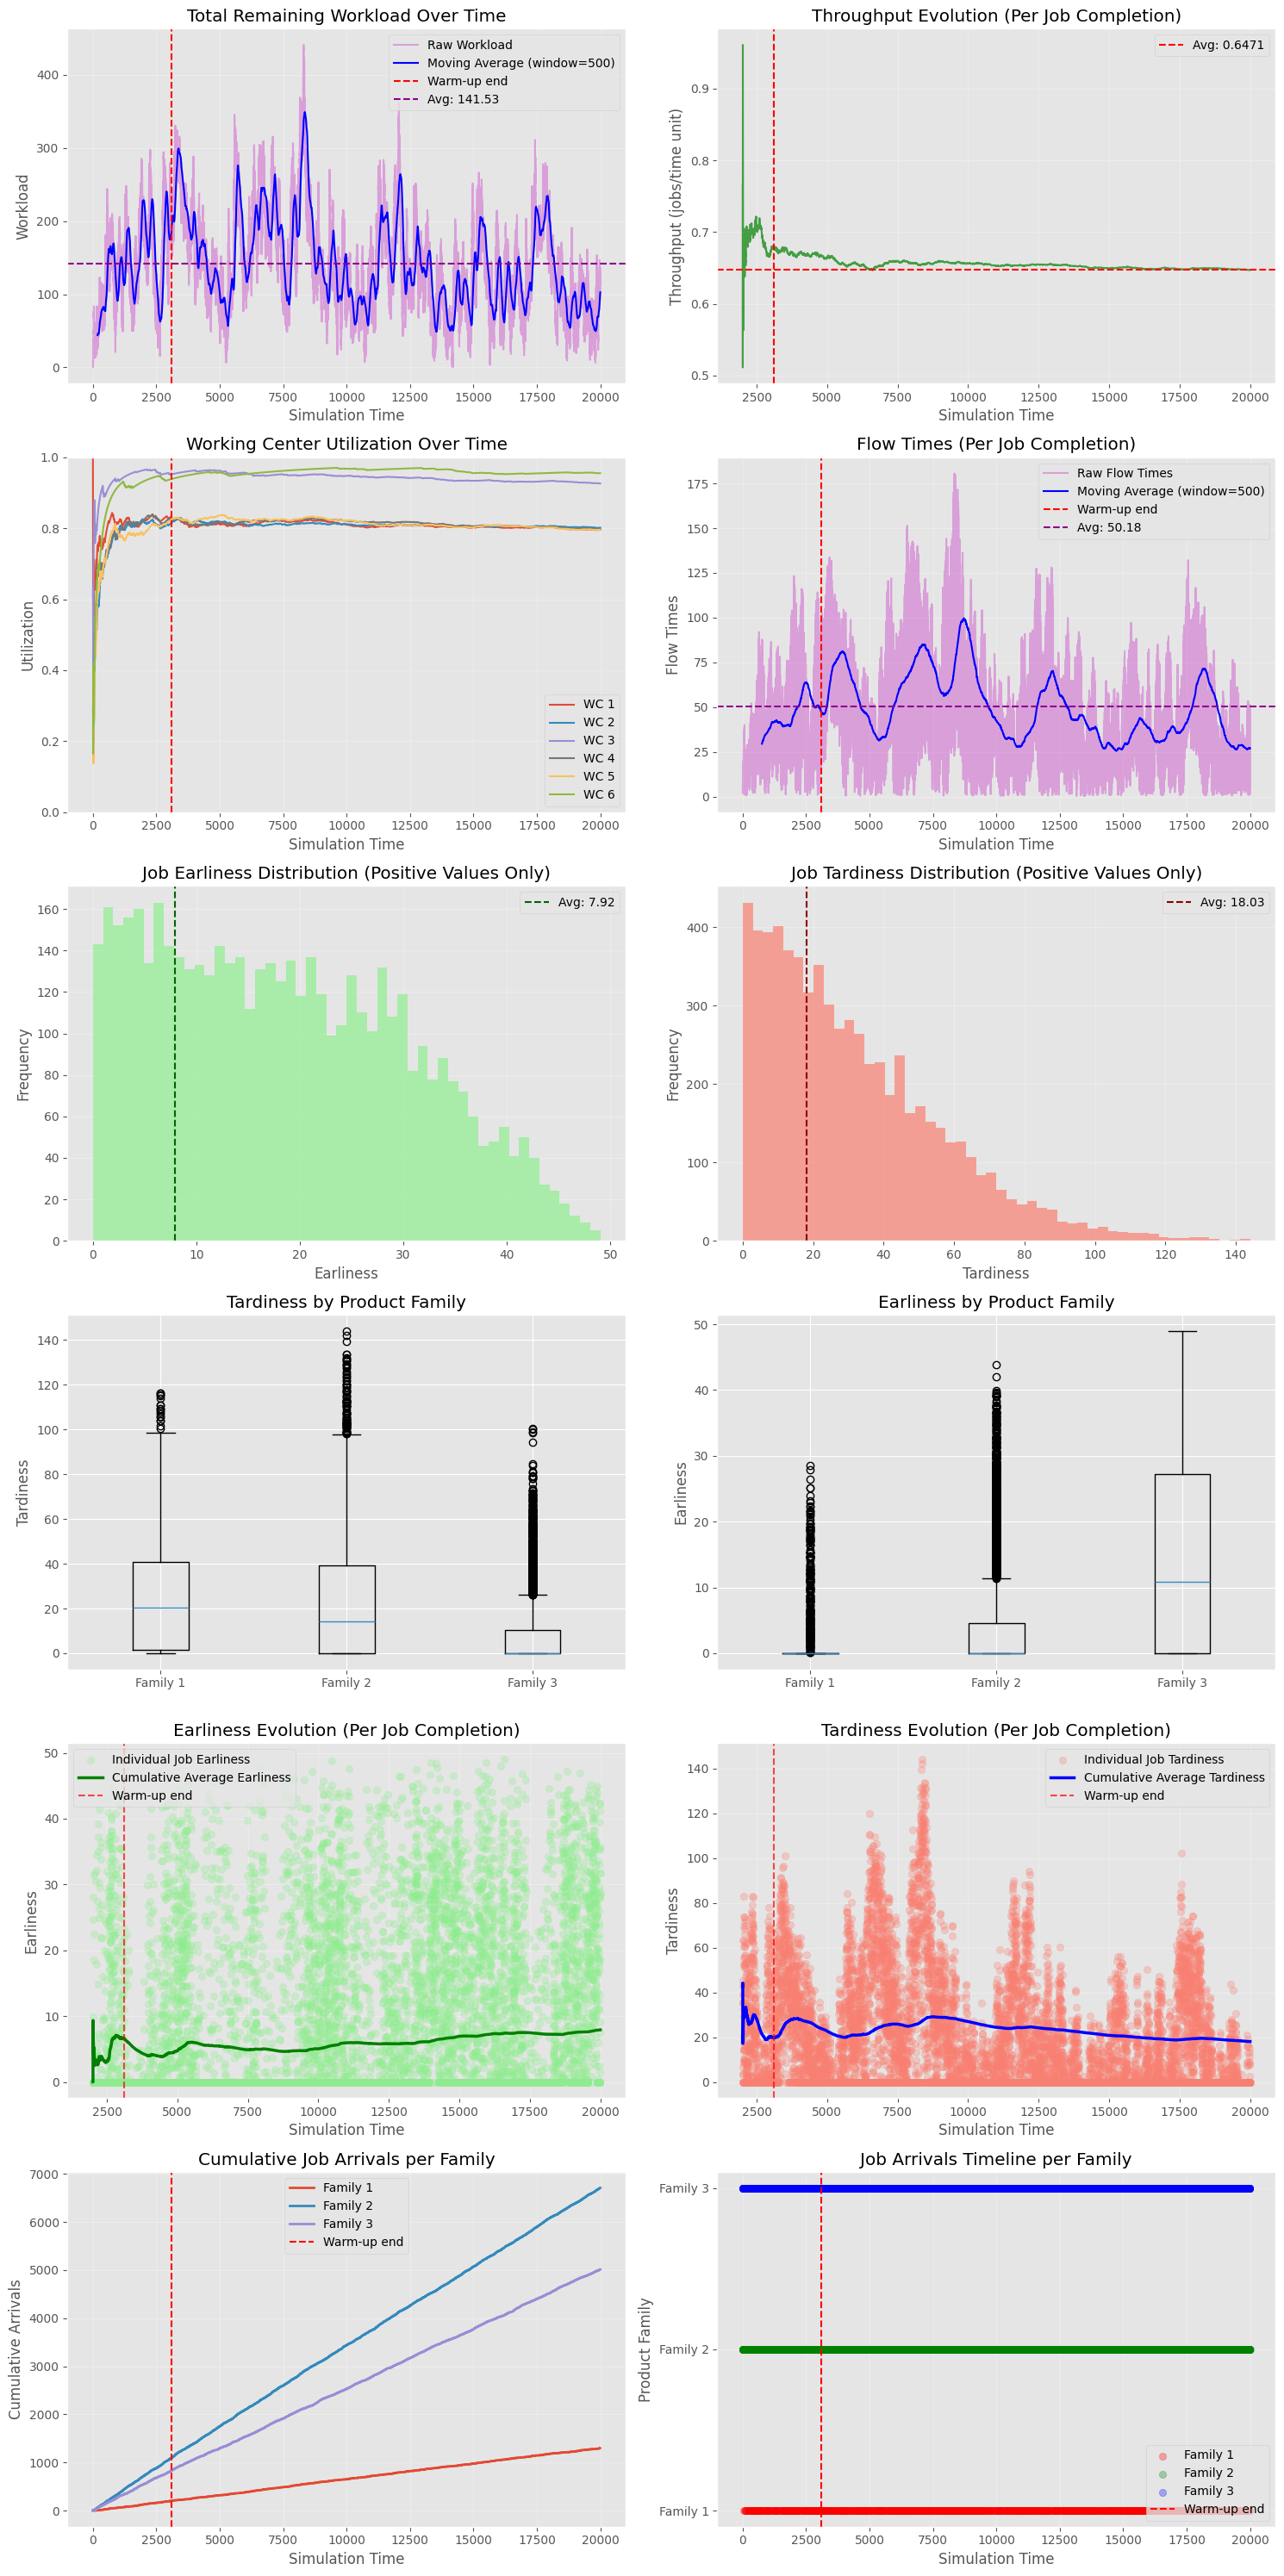

In [55]:
def moving_average(data, window_size=100):
    """Calculate moving average with specified window size"""
    if len(data) < window_size:
        return data
    
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def visualize_results(stats, kpis):
    """Create visualizations of simulation results"""
    # Create figure layout
    plt.figure(figsize=(15, 30))
    
    # Total Remaining Workload over time
    plt.subplot(6, 2, 1)
    if stats['workload_events']:
        # Sort events by time
        events = sorted(stats['workload_events'], key=lambda x: x[0])
        times, workloads = zip(*events)
        
        # Create step plot for raw workload
        plt.step(times, workloads, where='post', color='m', alpha=0.3, label='Raw Workload')
        
        # Calculate and plot moving average
        window_size = 500  # Adjust this to control smoothness
        if len(workloads) > window_size:
            smoothed = moving_average(workloads, window_size)
            # Adjust times to match smoothed data length
            plt.plot(times[window_size-1:], smoothed, 'b-', linewidth=1.5, 
                    label=f'Moving Average (window={window_size})')
        
        plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
        plt.axhline(kpis['Average Total Remaining Workload'], color='darkmagenta', 
                   linestyle='--', label=f'Avg: {kpis["Average Total Remaining Workload"]:.2f}')
        plt.title('Total Remaining Workload Over Time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Workload')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No workload data available', 
                 ha='center', va='center', fontsize=12)
        plt.title('Total Remaining Workload Over Time')
    
    # Throughput over time (updated per completion)
    plt.subplot(6, 2, 2)
    if stats['throughput_over_time']:
        t_time, throughput = zip(*stats['throughput_over_time'])
        plt.plot(t_time, throughput, 'g-', alpha=0.7)
        plt.axhline(kpis['Throughput (jobs/time unit)'], color='r', linestyle='--', 
                   label=f'Avg: {kpis["Throughput (jobs/time unit)"]:.4f}')
        plt.axvline(WARM_UP, color='r', linestyle='--')
        plt.title('Throughput Evolution (Per Job Completion)')
        plt.xlabel('Simulation Time')
        plt.ylabel('Throughput (jobs/time unit)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Utilization over time
    plt.subplot(6, 2, 3)
    for wc in WC_IDS:
        if stats['wc_utilization'][wc]:
            util_time, util = zip(*stats['wc_utilization'][wc])
            plt.plot(util_time, util, label=f'WC {wc}')
    plt.axvline(WARM_UP, color='r', linestyle='--')
    plt.title('Working Center Utilization Over Time')
    plt.xlabel('Simulation Time')
    plt.ylabel('Utilization')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Tardiness distribution (only positive values)
    plt.subplot(6, 2, 6)
    if stats['tardiness']:
        # Filter out zero tardiness values
        positive_tardiness = [t for t in stats['tardiness'] if t > 0]
        
        if positive_tardiness:
            plt.hist(positive_tardiness, bins=50, color='salmon', alpha=0.7)
            plt.axvline(kpis['Average Tardiness'], color='darkred', 
                       linestyle='--', label=f'Avg: {kpis["Average Tardiness"]:.2f}')
            plt.title('Job Tardiness Distribution (Positive Values Only)')
            plt.xlabel('Tardiness')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # Earliness distribution (only positive values)
    plt.subplot(6, 2, 5)
    if stats['earliness']:
        # Filter out zero earliness values
        positive_earliness = [e for e in stats['earliness'] if e > 0]
        
        if positive_earliness:
            plt.hist(positive_earliness, bins=50, color='lightgreen', alpha=0.7)
            plt.axvline(kpis['Average Earliness'], color='darkgreen', 
                       linestyle='--', label=f'Avg: {kpis["Average Earliness"]:.2f}')
            plt.title('Job Earliness Distribution (Positive Values Only)')
            plt.xlabel('Earliness')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    # Flow time graph
    plt.subplot(6, 2, 4)
    if stats['flow_times']:
        # Sort events by time
        events = sorted(stats['flow_times'], key=lambda x: x[0])
        times, flow_times = zip(*events)
        
        # Create step plot for raw flow_times
        plt.step(times, flow_times, where='post', color='m', alpha=0.3, label='Raw Flow Times')
        
        # Calculate and plot moving average
        window_size = 500  # Adjust this to control smoothness
        if len(flow_times) > window_size:
            smoothed = moving_average(flow_times, window_size)
            # Adjust times to match smoothed data length
            plt.plot(times[window_size-1:], smoothed, 'b-', linewidth=1.5, 
                    label=f'Moving Average (window={window_size})')
        
        plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
        plt.axhline(kpis['Average Flow Times'], color='darkmagenta', 
                   linestyle='--', label=f'Avg: {kpis["Average Flow Times"]:.2f}')
        plt.title('Flow Times (Per Job Completion)')
        plt.xlabel('Simulation Time')
        plt.ylabel('Flow Times')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No flow_times data available', 
                 ha='center', va='center', fontsize=12)
        plt.title('Flow Times (Per Job Completion)')
        
    
    # Family-specific performance
    plt.subplot(6,2,7)
    
    # Family tardiness
    family_tardiness = [
        stats['family_tardiness'][1],
        stats['family_tardiness'][2],
        stats['family_tardiness'][3]
    ]
    plt.boxplot(family_tardiness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    plt.title('Tardiness by Product Family')
    plt.ylabel('Tardiness')
    
    # Family earliness
    plt.subplot(6,2,8)
    family_earliness = [
        stats['family_earliness'][1],
        stats['family_earliness'][2],
        stats['family_earliness'][3]
    ]
    plt.boxplot(family_earliness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    plt.title('Earliness by Product Family')
    plt.ylabel('Earliness')
    
    # Cumulative arrivals
    plt.subplot(6,2,11)
    for family in [1, 2, 3]:
        arrival_times = sorted(stats['arrival_times'][family])
        cumulative_counts = np.arange(1, len(arrival_times) + 1)
        plt.step(arrival_times, cumulative_counts, where='post', 
                label=f'Family {family}', linewidth=2)
    
    plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
    plt.title('Cumulative Job Arrivals per Family')
    plt.xlabel('Simulation Time')
    plt.ylabel('Cumulative Arrivals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Arrival events timeline
    plt.subplot(6,2,12)
    colors = {1: 'red', 2: 'green', 3: 'blue'}
    for family in [1, 2, 3]:
        arrival_times = stats['arrival_times'][family]
        plt.scatter(arrival_times, [family]*len(arrival_times), 
                   color=colors[family], alpha=0.3, label=f'Family {family}')
    
    plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
    plt.title('Job Arrivals Timeline per Family')
    plt.xlabel('Simulation Time')
    plt.ylabel('Product Family')
    plt.yticks([1, 2, 3], ['Family 1', 'Family 2', 'Family 3'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    

    # plot tardiness over time
    plt.subplot(6,2,10)
    
    if not stats['tardiness_over_time']:
        plt.text(0.5, 0.5, 'No tardiness data available', 
                 ha='center', va='center', fontsize=16)
        plt.title('Tardiness Evolution (Per Job Completion)')
        return
    
    # Extract and sort data
    times, tardiness = zip(*stats['tardiness_over_time'])
    sorted_idx = np.argsort(times)
    times = np.array(times)[sorted_idx]
    tardiness = np.array(tardiness)[sorted_idx]
    
    # Calculate cumulative average
    cum_avg = np.cumsum(tardiness) / (np.arange(len(tardiness)) + 1)
    
    # Create plot
    plt.scatter(times, tardiness, alpha=0.3, color='salmon', 
                label='Individual Job Tardiness')
    plt.plot(times, cum_avg, 'b-', linewidth=2.5, 
             label='Cumulative Average Tardiness')
    
    plt.axvline(WARM_UP, color='r', linestyle='--', alpha=0.7, label='Warm-up end')
    plt.title('Tardiness Evolution (Per Job Completion)')
    plt.xlabel('Simulation Time')
    plt.ylabel('Tardiness')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # plot earliness over time
    plt.subplot(6,2,9)
    
    if not stats['earliness_over_time']:
        plt.text(0.5, 0.5, 'No earliness data available', 
                ha='center', va='center', fontsize=16)
        plt.title('Earliness Evolution (Per Job Completion)')
        return
    
    # Extract and sort data
    times, earliness = zip(*stats['earliness_over_time'])
    sorted_idx = np.argsort(times)
    times = np.array(times)[sorted_idx]
    earliness = np.array(earliness)[sorted_idx]
    
    # Calculate cumulative average
    cum_avg = np.cumsum(earliness) / (np.arange(len(earliness)) + 1)
    
    # Create plot
    plt.scatter(times, earliness, alpha=0.3, color='lightgreen', 
                label='Individual Job Earliness')
    plt.plot(times, cum_avg, 'g-', linewidth=2.5, 
            label='Cumulative Average Earliness')
    
    plt.axvline(WARM_UP, color='r', linestyle='--', alpha=0.7, label='Warm-up end')
    plt.title('Earliness Evolution (Per Job Completion)')
    plt.xlabel('Simulation Time')
    plt.ylabel('Earliness')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



# Visualize results
if kpis:
    visualize_results(stats, kpis)

## Welch's method

=========== Starting Welch's Method for Warm-up Period Determination ===========
Running 10 replications of length 20000...
Reference measure: Utilization of WC6
Moving average window: 100

Running replication 1/10...
  Collected 10079 utilization points

Running replication 2/10...
  Collected 9990 utilization points

Running replication 3/10...
  Collected 9922 utilization points

Running replication 4/10...
  Collected 9916 utilization points

Running replication 5/10...
  Collected 10153 utilization points

Running replication 6/10...
  Collected 10121 utilization points

Running replication 7/10...
  Collected 9957 utilization points

Running replication 8/10...
  Collected 10118 utilization points

Running replication 9/10...
  Collected 10014 utilization points

Running replication 10/10...
  Collected 10080 utilization points


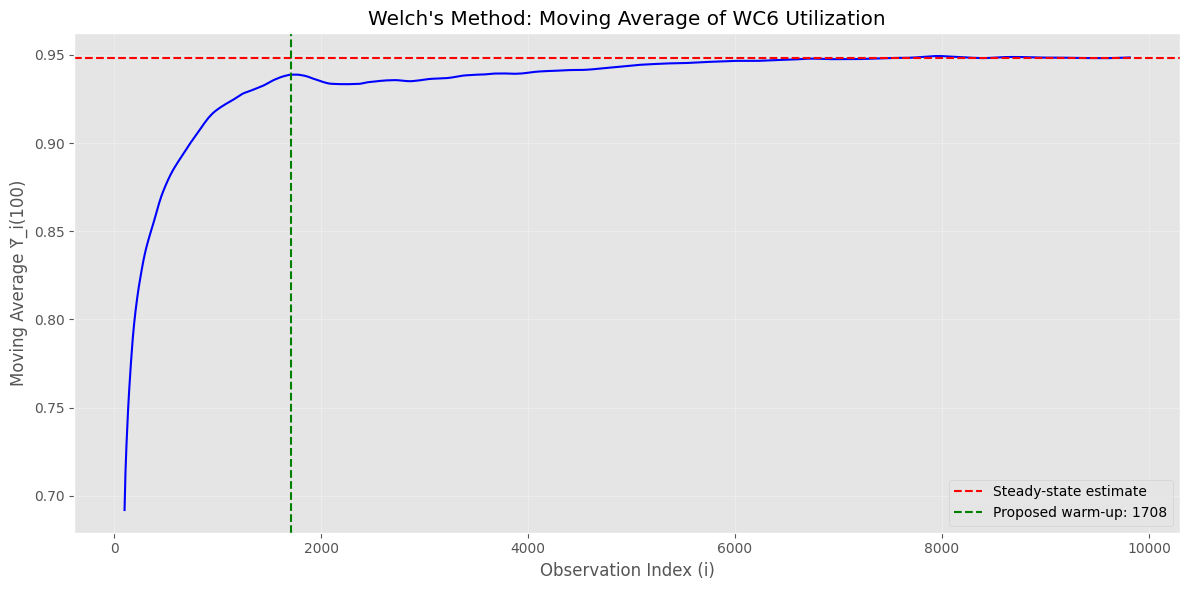


============================ Welch's Method Results ============================
Proposed warm-up period: 1708
Steady-state utilization estimate: 0.9482

Updated warm-up period: 1708


In [56]:
def welch_method(n_replications=10, window_size=100):
    """
    Perform Welch's method to determine warm-up period using WC6 utilization as reference measure
    """
    print("="*80)
    print(" Starting Welch's Method for Warm-up Period Determination ".center(80, '='))
    print("="*80)
    print(f"Running {n_replications} replications of length {SIM_TIME}...")
    print(f"Reference measure: Utilization of WC6")
    print(f"Moving average window: {window_size}")
    
    # Collect utilization data for WC6 from all replications
    all_replications_util = []
    minimum_number_of_observations = float('inf')
    for rep in range(n_replications):
        print(f"\nRunning replication {rep+1}/{n_replications}...")
        stats = run_simulation()
        wc6_util = stats['wc_utilization'][6]
        util_values = [val for _, val in wc6_util]
        all_replications_util.append(util_values)
        print(f"  Collected {len(util_values)} utilization points")
        if len(util_values) < minimum_number_of_observations:
            minimum_number_of_observations = len(util_values)

    for i, replication in enumerate(all_replications_util):
        all_replications_util[i] = replication[:minimum_number_of_observations]
    
    # Convert to numpy array (each row is a replication)
    util_matrix = np.array(all_replications_util)
    m = util_matrix.shape[1]  # Number of observations
    
    # Step 2: Compute cross-replication average Ȳ_i
    Y_bar = np.mean(util_matrix, axis=0)
    
    # Step 3: Compute moving averages Ȳ_i(w)
    Y_bar_moving = np.zeros(m - 2 * window_size)
    
    for i in range(window_size, m - window_size):
        # Handle boundaries differently
        if i < window_size:
            # Use all available points from start to i
            Y_bar_moving[i] = np.mean(Y_bar[max(0, i - window_size):min(m, i + window_size + 1)])
        else:
            # Standard moving average
            Y_bar_moving[i - window_size] = np.mean(Y_bar[i - window_size:i + window_size + 1])
    
    # Create time axis for plotting
    time_axis = np.arange(window_size, m - window_size)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, Y_bar_moving, 'b-', linewidth=1.5)
    plt.title('Welch\'s Method: Moving Average of WC6 Utilization')
    plt.xlabel('Observation Index (i)')
    plt.ylabel(f'Moving Average Ȳ_i({window_size})')
    plt.grid(True, alpha=0.3)
    
    # Add convergence indicators
    plt.axhline(y=float(np.mean(Y_bar_moving[-100:])), color='r', linestyle='--', 
                label='Steady-state estimate')
    
    # Identify warm-up period visually
    steady_state_value = np.mean(Y_bar_moving[-500:])  # Last 500 points
    convergence_index = None
    
    # Find where the curve enters ±1% of steady-state value
    for i, val in enumerate(Y_bar_moving):
        if abs(val - steady_state_value) < 0.01 * steady_state_value:
            convergence_index = i + window_size
            plt.axvline(x=convergence_index, color='g', linestyle='--', 
                        label=f'Proposed warm-up: {convergence_index}')
            break
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Determine warm-up period
    if convergence_index is None:
        print("Warning: No clear convergence point found!")
        print("Using default warm-up period of 5,000")
        return 5000
    
    print("\n" + "="*80)
    print(f" Welch's Method Results ".center(80, '='))
    print("="*80)
    print(f"Proposed warm-up period: {convergence_index}")
    print(f"Steady-state utilization estimate: {steady_state_value:.4f}")
    
    return convergence_index

# Run Welch's method to determine optimal warm-up period
WARM_UP = welch_method(n_replications=10, window_size=100)
print(f"\nUpdated warm-up period: {WARM_UP}")

## Compute confidence intervals

In [59]:
def sequential_confidence_interval(primary_metric: str = 'Average Tardiness', 
                                   metrics: list[str] = ['Average jobs in system (L)', 
                                                         'Average Total Remaining Workload',
                                                         'Average Flow Times' ,
                                                         'Average Tardiness', 
                                                         'Average Earliness', 
                                                         'Throughput (jobs/time unit)'], 
                                   alpha=0.05, 
                                   gamma=0.05
                                   ):
    """Compute confidence intervals using sequential procedure"""
    n0 = 10
    n = n0
    replications = []
    primary_metric_values = []
    
    print(f"Running sequential confidence interval procedure (α={alpha}, γ={gamma})")
    print(f'Primary metric: {primary_metric}')
    print(f"Initial replications: {n0}")
    
    # Run initial replications
    for i in range(n0):
        print(f"  Running replication {i+1}/{n0}")
        stats = run_simulation()
        kpis = compute_kpis_from_stats(stats)
        replications.append(kpis)
        primary_metric_values.append(kpis[primary_metric])
    
    # Sequential procedure
    converged = False
    
    while not converged:
        # Calculate statistics for primary metric (average tardiness)
        X = np.array(primary_metric_values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)  # Sample variance
        
        # Skip if no variance
        if S2 == 0 or len(X) == 1:
            half_width = 0
            rel_error = 0
        else:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
            rel_error = half_width / abs(X_bar) if X_bar != 0 else float('inf')
        
        print(f"Replications: {n}, Mean tardiness: {X_bar:.4f}, "
              f"Half-width: {half_width:.4f}, Rel error: {rel_error:.4f}")
        
        # Check convergence
        if rel_error <= gamma:
            converged = True
            print(f"\nConverged after {n} replications with relative error {rel_error:.4f} <= {gamma}")
        else:
            n += 1
            print(f"  Running additional replication {n}")
            stats = run_simulation()
            kpis = compute_kpis_from_stats(stats)
            replications.append(kpis)
            primary_metric_values.append(kpis[primary_metric])
    
    # Compute final confidence intervals for all KPIs
    confidence_intervals = {}
    
    # Scalar KPIs
    for k in metrics:
        values = [rep[k] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        confidence_intervals[k] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    
    # WC utilization
    wc_util_ci = {}
    for wc in WC_IDS:
        values = [rep['Working Center Utilization'][wc] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        wc_util_ci[wc] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    confidence_intervals['Working Center Utilization'] = wc_util_ci
    
    # WC queue times
    wc_queue_ci = {}
    for wc in WC_IDS:
        values = [rep['Average Queue Times'][wc] for rep in replications]
        X = np.array(values)
        X_bar = np.mean(X)
        S2 = np.var(X, ddof=1)
        
        if n > 1:
            t_value = scipy.stats.t.ppf(1 - alpha/2, n-1)
            half_width = t_value * np.sqrt(S2 / n)
        else:
            half_width = 0
            
        wc_queue_ci[wc] = {
            'mean': X_bar,
            'ci_lower': X_bar - half_width,
            'ci_upper': X_bar + half_width,
            'half_width': half_width
        }
    confidence_intervals['Average Queue Times'] = wc_queue_ci
    
    return confidence_intervals, n

# Run the confidence interval calculation
ALPHA = 0.05  # 95% confidence level
GAMMA = 0.05  # 5% relative error

print("\n" + "="*80)
print(" Calculating Confidence Intervals ".center(80, '='))
print("="*80)

random.seed(42)  # For reproducibility
confidence_intervals, n_reps = sequential_confidence_interval(
    primary_metric='Average Tardiness',alpha=ALPHA, gamma=GAMMA
)


======================= Calculating Confidence Intervals =======================
Running sequential confidence interval procedure (α=0.05, γ=0.05)
Primary metric: Average Tardiness
Initial replications: 10
  Running replication 1/10
  Running replication 2/10
  Running replication 3/10
  Running replication 4/10
  Running replication 5/10
  Running replication 6/10
  Running replication 7/10
  Running replication 8/10
  Running replication 9/10
  Running replication 10/10
Replications: 10, Mean tardiness: 18.6049, Half-width: 6.7017, Rel error: 0.3602
  Running additional replication 11
Replications: 11, Mean tardiness: 19.2192, Half-width: 6.1256, Rel error: 0.3187
  Running additional replication 12
Replications: 12, Mean tardiness: 19.4574, Half-width: 5.5486, Rel error: 0.2852
  Running additional replication 13
Replications: 13, Mean tardiness: 19.9838, Half-width: 5.1811, Rel error: 0.2593
  Running additional replication 14
Replications: 14, Mean tardiness: 19.8839, Half-width:

In [60]:
# Print confidence interval results
def print_confidence_intervals(ci_dict):
    print("\n" + " Confidence Intervals ".center(80, '-'))
    for metric, data in ci_dict.items():
        if isinstance(data, dict) and 'mean' in data:
            # Scalar metric
            print(f"{metric.replace('_', ' ').title()}:")
            print(f"  Mean: {data['mean']:.4f}")
            print(f"  95% CI: ({data['ci_lower']:.4f}, {data['ci_upper']:.4f})")
            print(f"  Half-width: {data['half_width']:.4f}")
            print(f"  Relative Precision: {data['half_width']/abs(data['mean']):.4f}" 
                  if data['mean'] != 0 else "  Relative Precision: undefined (mean=0)")
        elif isinstance(data, dict):
            # Nested dictionary (WC metrics)
            print(f"\n{metric.replace('_', ' ').title()}:")
            for wc, wc_data in data.items():
                print(f"  WC {wc}:")
                print(f"    Mean: {wc_data['mean']:.4f}")
                print(f"    95% CI: ({wc_data['ci_lower']:.4f}, {wc_data['ci_upper']:.4f})")
                print(f"    Half-width: {wc_data['half_width']:.4f}")
                print(f"    Relative Precision: {wc_data['half_width']/abs(wc_data['mean']):.4f}" 
                      if wc_data['mean'] != 0 else "    Relative Precision: undefined (mean=0)")

print_confidence_intervals(confidence_intervals)


----------------------------- Confidence Intervals -----------------------------
Average Jobs In System (L):
  Mean: 34.1206
  95% CI: (33.3422, 34.8990)
  Half-width: 0.7784
  Relative Precision: 0.0228
Average Total Remaining Workload:
  Mean: 152.1148
  95% CI: (149.8234, 154.4061)
  Half-width: 2.2913
  Relative Precision: 0.0151
Average Flow Times:
  Mean: 52.4520
  95% CI: (51.2951, 53.6088)
  Half-width: 1.1569
  Relative Precision: 0.0221
Average Tardiness:
  Mean: 20.8015
  95% CI: (19.7634, 21.8396)
  Half-width: 1.0381
  Relative Precision: 0.0499
Average Earliness:
  Mean: 8.3470
  95% CI: (8.1979, 8.4961)
  Half-width: 0.1491
  Relative Precision: 0.0179
Throughput (Jobs/Time Unit):
  Mean: 0.6497
  95% CI: (0.6491, 0.6503)
  Half-width: 0.0006
  Relative Precision: 0.0010

Working Center Utilization:
  WC 1:
    Mean: 0.7997
    95% CI: (0.7983, 0.8010)
    Half-width: 0.0014
    Relative Precision: 0.0017
  WC 2:
    Mean: 0.7999
    95% CI: (0.7986, 0.8013)
    Half-wi